    lead_source    industry  number_of_courses_viewed  annual_income  \
0      paid_ads         NaN                         1        79450.0   
1  social_media      retail                         1        46992.0   
2        events  healthcare                         5        78796.0   
3      paid_ads      retail                         2        83843.0   
4      referral   education                         3        85012.0   

  employment_status       location  interaction_count  lead_score  converted  
0        unemployed  south_america                  4        0.94          1  
1          employed  south_america                  1        0.80          0  
2        unemployed      australia                  3        0.69          1  
3               NaN      australia                  1        0.87          0  
4     self_employed         europe                  3        0.62          1  


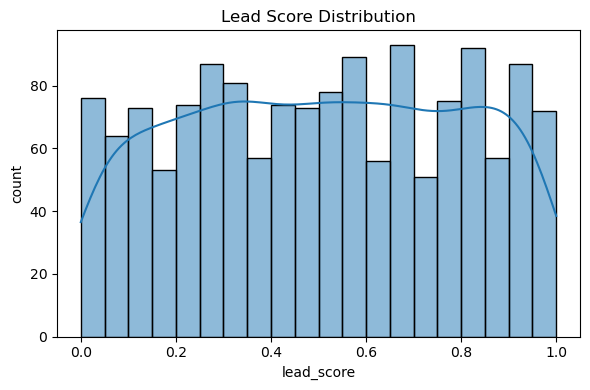

Loaded data and displayed head and a histogram of lead_score


In [30]:
# Load libraries and the CSV; show head and a quick visualization for context.
# Keep imports separate to ensure environment is ready, and display a simple plot.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Read data
df_full = pd.read_csv('course_lead_scoring.csv', encoding='ascii')

# Preview
print(df_full.head())

# Simple visualization: distribution of lead_score
plt.figure(figsize=(6,4))
sns.histplot(df_full['lead_score'], bins=20, kde=True)
plt.title('Lead Score Distribution')
plt.xlabel('lead_score')
plt.ylabel('count')
plt.tight_layout()
plt.show()

print('Loaded data and displayed head and a histogram of lead_score')

         lead_source    industry  number_of_courses_viewed  annual_income  \
1148              NA  technology                         2        61066.0   
555         paid_ads          NA                         1        72926.0   
600   organic_search  technology                         3        59656.0   
1262    social_media  healthcare                         3        46510.0   
792         referral  healthcare                         3        35772.0   

     employment_status       location  interaction_count  lead_score  
1148          employed           asia                  1        0.36  
555      self_employed  south_america                  2        0.71  
600         unemployed    middle_east                  4        0.65  
1262        unemployed         europe                  3        0.27  
792           employed  north_america                  2        0.67  
Completed data prep and 60/20/20 split
{'number_of_courses_viewed': 0.7519093679314673, 'annual_income': 0.5674

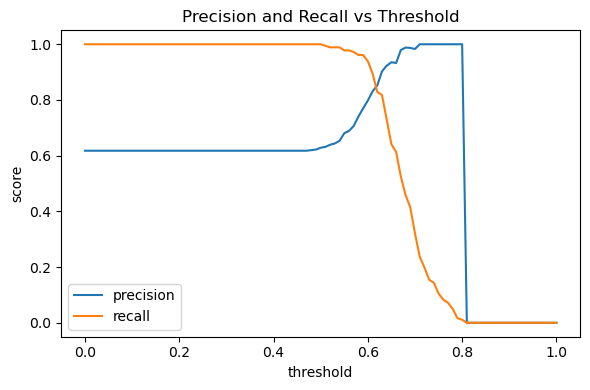

0.81
0.6


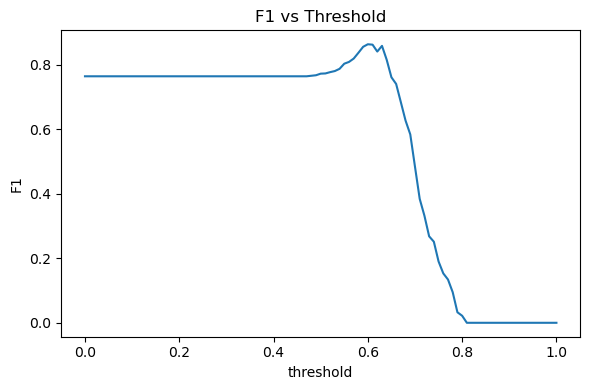

Computed Q1-Q4 metrics and plots
[0.817, 0.779, 0.831, 0.868, 0.809]
0.821
Completed 5-fold CV


In [31]:
# Data prep per homework: handle missing, split, then Q1-Q5 computations with visuals and prints.
# Keep steps compact and print key results; also plot precision-recall curves.

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
import numpy as np
import matplotlib.pyplot as plt

# 1) Data prep: fillna rules
cat_cols = ['lead_source','industry','employment_status','location']
num_cols = ['number_of_courses_viewed','annual_income','interaction_count','lead_score']
df_prep = df_full.copy()
df_prep[cat_cols] = df_prep[cat_cols].fillna('NA')
df_prep[num_cols] = df_prep[num_cols].fillna(0.0)

# Split 60/20/20 with random_state=1
X = df_prep.drop(columns=['converted'])
y = df_prep['converted'].values
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=1, stratify=y_temp)
# now train: 60%, val: 20%, test: 20%

print(pd.DataFrame(X_train.head()))
print('Completed data prep and 60/20/20 split')

# Q1: ROC AUC feature importance for numerical variables on training set
aucs = {}
for c in num_cols:
    scores = X_train[c].values
    auc = roc_auc_score(y_train, scores)
    if auc < 0.5:
        scores = -scores
        auc = roc_auc_score(y_train, scores)
    aucs[c] = auc

best_num = sorted(aucs.items(), key=lambda kv: kv[1], reverse=True)[0]
print(aucs)
print(best_num[0])

# Q2: One-hot + LogisticRegression
train_dicts = X_train.to_dict(orient='records')
val_dicts = X_val.to_dict(orient='records')

dv = DictVectorizer(sparse=True)
X_train_dv = dv.fit_transform(train_dicts)
X_val_dv = dv.transform(val_dicts)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train_dv, y_train)
val_proba = model.predict_proba(X_val_dv)[:,1]
auc_val = roc_auc_score(y_val, val_proba)
print(round(auc_val,3))

# Q3: precision and recall across thresholds; plot and find intersection
prec, rec, thr = precision_recall_curve(y_val, val_proba)
# precision_recall_curve returns last point at threshold None; construct thresholds 0..1 step 0.01
thresholds = np.arange(0.0, 1.0001, 0.01)
P = []
R = []
for t in thresholds:
    preds = (val_proba >= t).astype(int)
    tp = np.sum((preds==1) & (y_val==1))
    fp = np.sum((preds==1) & (y_val==0))
    fn = np.sum((preds==0) & (y_val==1))
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    P.append(precision)
    R.append(recall)

plt.figure(figsize=(6,4))
plt.plot(thresholds, P, label='precision')
plt.plot(thresholds, R, label='recall')
plt.xlabel('threshold')
plt.ylabel('score')
plt.title('Precision and Recall vs Threshold')
plt.legend()
plt.tight_layout()
plt.show()

# find closest intersection where |P-R| minimal
idx_int = int(np.argmin(np.abs(np.array(P) - np.array(R))))
thr_int = thresholds[idx_int]
print(round(thr_int,3))

# Q4: F1 across thresholds
F1 = []
for p, r in zip(P, R):
    f1 = 2*p*r/(p+r) if (p+r) > 0 else 0.0
    F1.append(f1)
idx_f1 = int(np.argmax(np.array(F1)))
thr_f1 = thresholds[idx_f1]
print(round(thr_f1,3))

plt.figure(figsize=(6,4))
plt.plot(thresholds, F1)
plt.xlabel('threshold')
plt.ylabel('F1')
plt.title('F1 vs Threshold')
plt.tight_layout()
plt.show()

print('Computed Q1-Q4 metrics and plots')

# Q5: 5-Fold CV with same pipeline, report AUCs
kf = KFold(n_splits=5, shuffle=True, random_state=1)
auc_scores = []
for train_idx, val_idx in kf.split(df_prep):
    df_tr = df_prep.iloc[train_idx]
    df_va = df_prep.iloc[val_idx]
    y_tr = df_tr['converted'].values
    y_va = df_va['converted'].values
    X_tr = df_tr.drop(columns=['converted'])
    X_va = df_va.drop(columns=['converted'])
    dv_cv = DictVectorizer(sparse=True)
    X_tr_dv = dv_cv.fit_transform(X_tr.to_dict(orient='records'))
    X_va_dv = dv_cv.transform(X_va.to_dict(orient='records'))
    m = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    m.fit(X_tr_dv, y_tr)
    proba = m.predict_proba(X_va_dv)[:,1]
    auc_fold = roc_auc_score(y_va, proba)
    auc_scores.append(auc_fold)

print([round(a,3) for a in auc_scores])
print(round(float(np.mean(auc_scores)),3))
print('Completed 5-fold CV')